## **Context**

In this notebook, we will build an image classifier that can distinguish Pituitary Tumor from "No Tumor" MRI Scan images. 

The dataset used in this notebook is available for download from [Kaggle](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri). 

The dataset actually has a total of 3,264 images belonging to 4 classes - Glioma Tumor, Meningioma Tumor, Pituitary Tumor and No Tumor.  

 In our problem, we will also be using Data Augmentation to prevent overfitting, and to make our model model more generalised and robust.

We will use this to build an image classification model for this problem statement, and then show how we can improve our performance by simply "importing" a popular pre-trained model architecture and leveraging the idea of **Transfer Learning**.

**Objective:**

The aim is to predict the brain tumor using the popular method called transfor learning.

To do so we will be using the VGG16 pre-trained model.




## **Importing Libraries**

In [2]:
# Library for creating data paths
import os

# Library for randomly selecting data points
import random

# Library for performing numerical computations
import numpy as np

# Library for creating and showing plots
import matplotlib.pyplot as plt

# Library for reading and showing images
import matplotlib.image as mpimg

# Importing all the required sub-modules from Keras
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout

Mounting the drive to load the dataset

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


We have stored the images in a structured folder, and below we create the data paths to load images from those folders. This is required so that we can extract images in an auto-labelled fashion using Keras **flow_from_directory**.

In [24]:
os.chdir('/content/drive/My Drive/DL/CNN/Brain Tumor Classification')

In [29]:
# Parent directory where images are stored in drive
parent_dir = 'archive'

# Path to the training and testing datasets within the parent directory
train_dir = os.path.join(parent_dir, 'Training')
test_dir = os.path.join(parent_dir, 'Testing')

# Directory with our training pictures
train_pituitary_dir = os.path.join(train_dir, 'pituitary_tumor')
train_glioma_dir = os.path.join(train_dir, 'glioma_tumor')
train_meningioma_dir = os.path.join(train_dir, 'meningioma_tumor')
train_no_dir = os.path.join(train_dir, 'no_tumor')

# Directory with our testing pictures
test_pituitary_dir = os.path.join(test_dir, 'pituitary_tumor')
test_glioma_dir = os.path.join(test_dir, 'glioma_tumor')
test_meningioma_dir = os.path.join(test_dir, 'meningioma_tumor')
test_no_dir = os.path.join(test_dir, 'no_tumor')

## **Visualizing a few images**

Before we move ahead and perform data augmentation, let's check out some of the images and see how they look like:

In [30]:
train_pituitary_file_names = os.listdir(train_pituitary_dir)
train_glioma_file_names = os.listdir(train_glioma_dir)
train_meningioma_file_names = os.listdir(train_meningioma_dir)
train_no_file_names = os.listdir(train_no_dir)

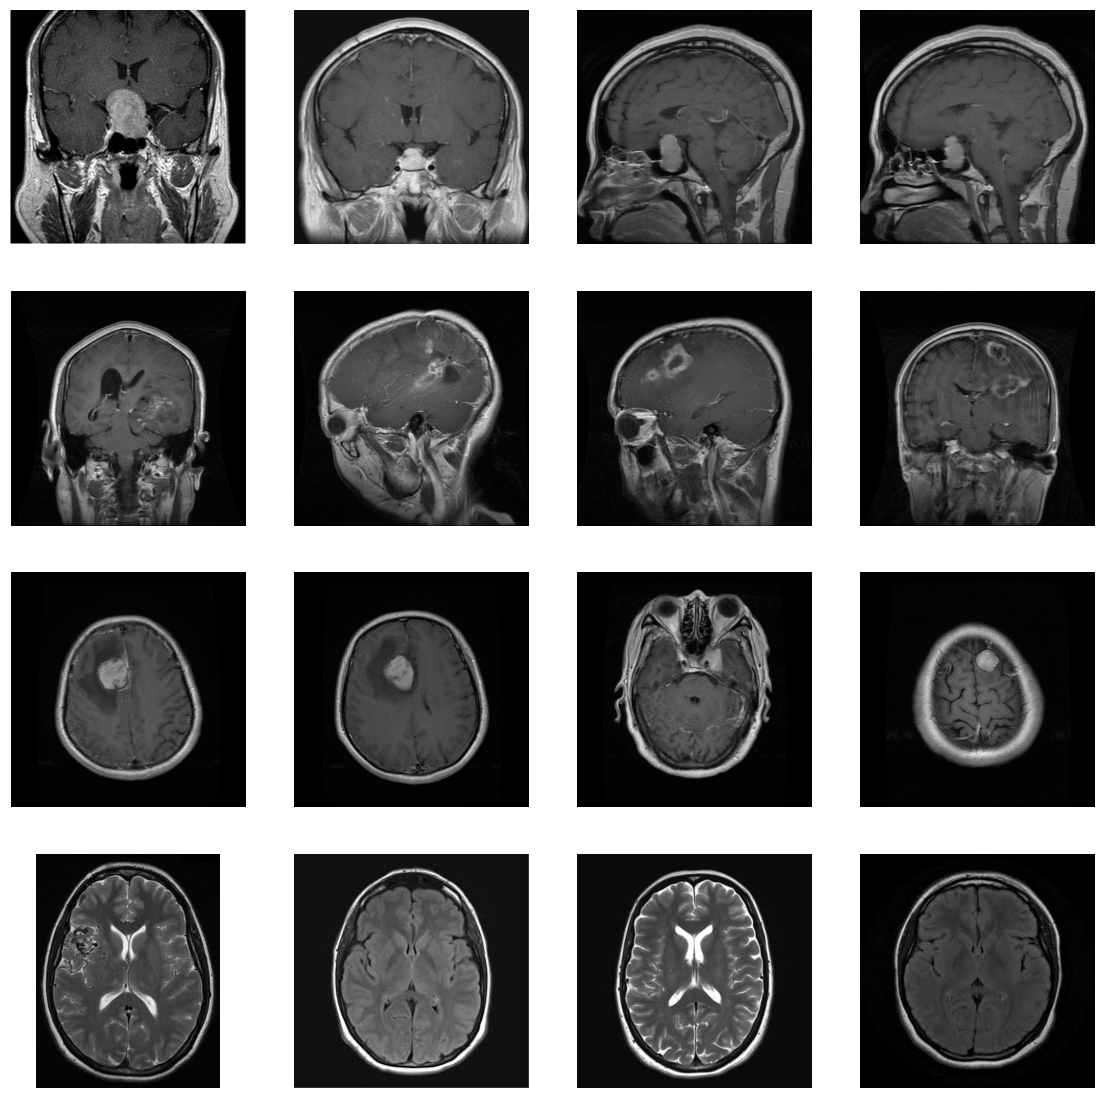

In [39]:
fig = plt.figure(figsize=(16, 8))
fig.set_size_inches(14, 14)

pituitary_img_paths = [os.path.join(train_pituitary_dir, file_name) for file_name in train_pituitary_file_names[:4]]
glioma_img_paths = [os.path.join(train_glioma_dir, file_name) for file_name in train_glioma_file_names[:4]]
meningioma_img_paths = [os.path.join(train_meningioma_dir, file_name) for file_name in train_meningioma_file_names[:4]]
no_img_paths = [os.path.join(train_no_dir, file_name) for file_name in train_no_file_names[:4]]

for i, img_path in enumerate(pituitary_img_paths + glioma_img_paths + meningioma_img_paths + no_img_paths):
    ax = plt.subplot(4, 4, i + 1)
    ax.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

As we can see, the images are quite different in size from each other.

This represents a problem, as most CNN architectures, including the pre-built model architectures that we will use for Transfer Learning, **expect all the images to have the same size.** 

So we need to crop these images from the center to make sure they all have the same size. We can do this automatically while performing Data Augmentation, as shown below.

## **Data Augmentation**

In most real-life case studies, it is generally difficult to collect lots of images and then train CNNs. In that case, one idea we can take advantage of is Data Augmentation. CNNs have the property of **translational invariance**, i.e., they can recognize an object as an object, even when its appearance varies translationally in some way. Taking this property into consideration, we can augment the images using the following techniques: 

**1. Horizontal Flip** (should be set to True/False) <br>
**2. Vertical Flip** (should be set to True/False) <br>
**3. Height Shift** (should be between 0 and 1) <br>
**4. Width Shift** (should be between 0 and 1) <br>
**5. Rotation** (should be between 0 and 180) <br>
**6. Shear** (should be between 0 and 1) <br>
**7. Zoom** (should be between 0 and 1) etc. <br>


Also, as mentioned above, we need to have images of the same size. So below,we resize the images by using the parameter **target_size**. Here we are resizing it to **224 x 224**, as we will be using the **VGG16** model for Transfer Learning, which takes image inputs as **224 x 224**. 

As this is a multi classification problem, we will need class labels. This is directly handled by the **flow_from_directory** function. It will take the images from the folder inside our specified directory, and the images from one folder will belong to same class.

As the train directory has 4 folders with tumor names, it will read the directory and each folder will be considered a separate class. We specify **class_model = 'categorical'** as this is a multi classification problem.

As the folders inside the directory will be read in an alphabetical order, the glioma_tumor folder will be given a label 0, meningioma_tumor will be given a label 1 and so on. 

In [41]:
# All images to be rescaled by 1/255.
train_datagen = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True,
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)
test_datagen  = ImageDataGenerator(rescale = 1.0/255.)

# Flowing training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=20,
                                                    class_mode='categorical',
                                                    target_size=(224, 224))     

# Flowing testing images in batches of 20 using test_datagen generator
test_generator =  test_datagen.flow_from_directory(test_dir,
                                                         batch_size=20,
                                                         class_mode  = 'categorical',
                                                         target_size = (224, 224))

Found 2870 images belonging to 4 classes.
Found 394 images belonging to 4 classes.


Let's look at some examples of our augmented training data. 

This is helpful for understanding the extent to which data is being manipulated prior to training, and can be compared with how the raw data looks prior to data augmentation.

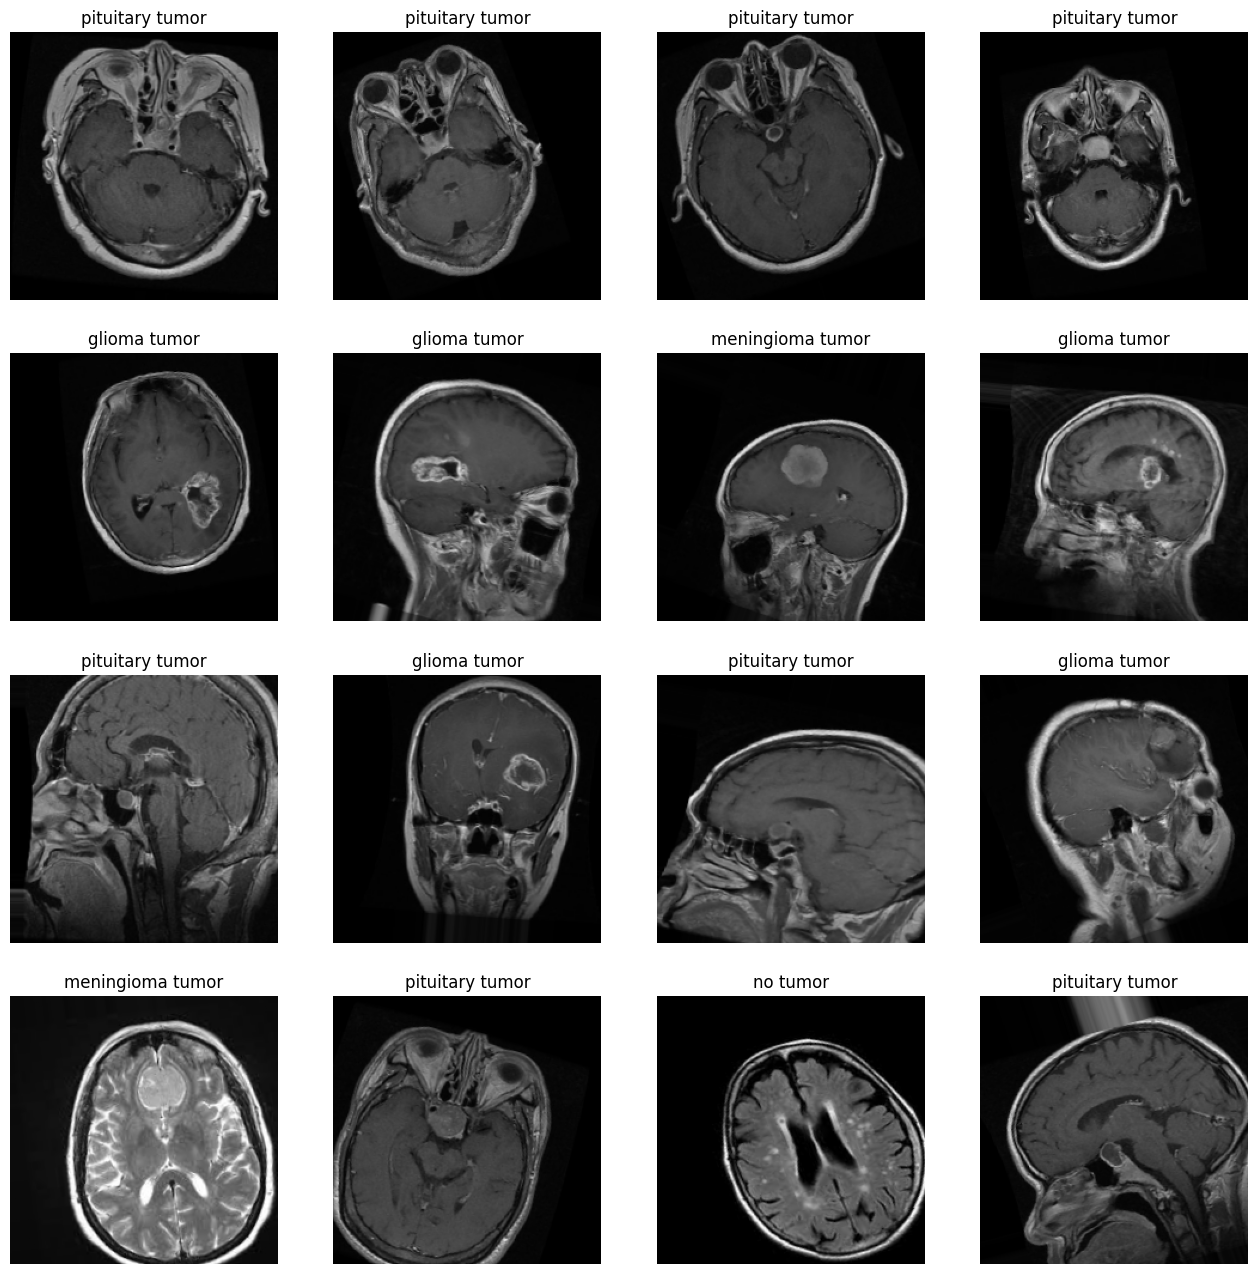

In [47]:
images, labels = next(train_generator)
fig, axes = plt.subplots(4, 4, figsize = (16, 8))
fig.set_size_inches(16, 16)
for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    if label[0] == 1: 
      ax.set_title('glioma tumor')
    elif label[1] == 1:
      ax.set_title('meningioma tumor')
    elif label[2] == 1:
      ax.set_title('no tumor')  
    else:
        ax.set_title('pituitary tumor')
    ax.axis('off')

## **Model Building using Transfer Learning: VGG 16**

- Now, let's try again, but this time, using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


## **Model Building using Transfer Learning: VGG 16**

- Now, let's try again, but this time, using the idea of **Transfer Learning**. We will be loading a pre-built architecture - **VGG16**, which was trained on the ImageNet dataset and finished runner-up in the ImageNet competition in 2014. Below is a schematic of the VGG16 model.

- For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. We will remove the already-present fully-connected layers and add our own fully-connected layers for this binary classification task.


![vgg16](https://upload.wikimedia.org/wikipedia/commons/2/24/VGG16.png)

In [64]:
# Pulling a single large batch of random testing data for testing after each epoch
testX, testY = test_generator.next()

In [70]:
from sklearn.model_selection import train_test_split
val_X,test_X,val_y,test_y = train_test_split(testX,testY,train_size=.5,random_state=110)

In [48]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 8s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [49]:
# Getting only the conv layers for transfer learning.
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)

In [50]:
vgg_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- To remove the fully-connected layers of the imported pre-trained model, while calling it from Keras we can also specify an additonal keyword argument that is **include_top**. 

- **If we specify include_top = False, then the model will be imported without the fully-connected layers.** Here we won't have to do the above steps of getting the last convolutional layer and creating a separate model.

- If we are specifying include_top = False, we will also have to specify our input image shape.

- Keras has this keyword argument as generally while importing a pre-trained CNN model, we don't require the fully-connected layers and we train our own fully-connected layers for our task.

In [71]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (224,224,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [72]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [60]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_3 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 False
block5_pool False


In [73]:
new_model = Sequential()

# Adding the convolutional part of the VGG16 model from above
new_model.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
new_model.add(Flatten())

# Adding a dense output layer
new_model.add(Dense(64, activation='relu'))
new_model.add(Dense(4, activation='sigmoid'))

In [74]:
new_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_3 (Flatten)         (None, 25088)             0         
                                                                 
 dense_9 (Dense)             (None, 64)                1605696   
                                                                 
 dense_10 (Dense)            (None, 4)                 260       
                                                                 
Total params: 16,320,644
Trainable params: 1,605,956
Non-trainable params: 14,714,688
_________________________________________________________________


In [77]:
## Fitting the VGG model
new_model_history = new_model.fit(train_generator, 
                                  validation_data=(val_X, val_y),
                                  epochs=10)

Epoch 1/10
144/144 [==============================] - 68s 471ms/step - loss: 0.2806 - accuracy: 0.8889 - val_loss: 0.7557 - val_accuracy: 0.7000
Epoch 2/10
144/144 [==============================] - 50s 348ms/step - loss: 0.2369 - accuracy: 0.9073 - val_loss: 1.2746 - val_accuracy: 0.7000
Epoch 3/10
144/144 [==============================] - 50s 346ms/step - loss: 0.2439 - accuracy: 0.9066 - val_loss: 1.2805 - val_accuracy: 0.6000
Epoch 4/10
144/144 [==============================] - 50s 345ms/step - loss: 0.2338 - accuracy: 0.9101 - val_loss: 1.4137 - val_accuracy: 0.5000
Epoch 5/10
144/144 [==============================] - 48s 333ms/step - loss: 0.2458 - accuracy: 0.9105 - val_loss: 0.7633 - val_accuracy: 0.7000
Epoch 6/10
144/144 [==============================] - 50s 347ms/step - loss: 0.2134 - accuracy: 0.9174 - val_loss: 1.3087 - val_accuracy: 0.7000
Epoch 7/10
144/144 [==============================] - 48s 335ms/step - loss: 0.2593 - accuracy: 0.9024 - val_loss: 0.9769 - val_ac

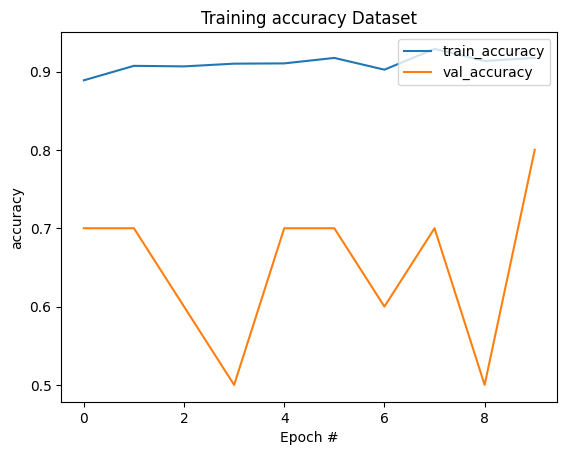

In [80]:
# Plotting the loss vs epoch curve for the Transfer Learning model
plot_history(new_model_history)

In [79]:
# Evaluating on the Test set
new_model.evaluate(test_X,test_y)

1/1 [==============================] - 0s 100ms/step - loss: 2.0386 - accuracy: 0.7000


[2.0386388301849365, 0.699999988079071]

### Findings

- Our model has 803,937 Trainable parameters.
- After running 10 epochs, This model able to predit brain tumor classes 70% accuratly on test images. We could also see that the model has been overfitted. 